# Generating geometric median composites (geomedians) <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. 

One approach is to create a [geomedian](https://github.com/daleroberts/hdmedians). 
A `geomedian` is based on a high-dimensional statistic called the 'geometric median' [(Small 1990)](https://www.jstor.org/stable/1403809), which effectively trades a temporal stack of poor quality observations for a single high-quality pixel composite with reduced spatial noise [(Roberts et al. 2017)](https://ieeexplore.ieee.org/abstract/document/8004469). 
In contrast to a standard median, a geomedian maintains the relationship between spectral bands. 
This allows us to conduct further analysis on the composite images just as we would on the original satellite images (e.g by allowing the calculation of common band indices like NDVI).

## Description
In this notebook we will take of time series of noisy satellite images collected over a year and calculate an annual geomedian composite which is largely free of clouds and other noisy data.

Geomedian computations are expensive in terms of memory, data bandwidth, and cpu usage. The ODC has some useful functions, [int_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) and [xr_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) that allow [dask](https://docs.dask.org/en/latest/) to perform the computation in parallel across many threads to speed things up. In this notebook a local dask cluster is used, but the same approach should work using a larger, distributed dask cluster.

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import numpy as np
import datacube
from odc.algo import to_f32, xr_geomedian, int_geomedian
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_dask import create_local_dask_cluster

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:38171 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Generating_geomedian_composites')

## Load Landsat 8 from the datacube

Here we are loading in a timeseries of cloud-masked Landsat 8 satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. 
This will provide us with some data to work with. To limit computation and memory this example uses only three optical bands (red, green, blue).

In [4]:
# Set up centre of area of interest, and area to buffer coordinates by
lat, lon = -12.25, 132.40
buffer = 0.1

# Create a reusable query
query = {
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'time': ('2018'),
    'measurements': ['nbart_green',
                     'nbart_red',
                     'nbart_blue'],
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:3577'
}

Compared to the typical use of `load_ard` which by default returns data with floating point numbers containing `NaN` (i.e. `float32`), in this example we will set the `dtype` to `'native'`. 
This will keep our data in its original integer data type (i.e. `Int16`), with nodata values marked with `-999`.
Doing this will halve the amount of memory our data takes up, which can be extremely valuable when conducting large-scale analyses.

In [5]:
# Load available data
ds = load_ard(dc=dc, 
              products=['ga_ls8c_ard_3'],
              dask_chunks={'x': 2000, 'y': 2000},
              dtype='native',
              **query)

# Print output data
ds

Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 23 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 23, x: 742, y: 727)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -1.281e+06 -1.281e+06 ... -1.302e+06 -1.302e+06
  * x            (x) float64 3.322e+04 3.326e+04 ... 5.542e+04 5.546e+04
  * time         (time) datetime64[ns] 2018-01-04T01:16:45.170611 ... 2018-12-22T01:16:29.649254
Data variables:
    nbart_green  (time, y, x) int16 dask.array<chunksize=(1, 727, 742), meta=np.ndarray>
    nbart_red    (time, y, x) int16 dask.array<chunksize=(1, 727, 742), meta=np.ndarray>
    nbart_blue   (time, y, x) int16 dask.array<chunksize=(1, 727, 742), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
Black areas indicate where clouds or other invalid pixels in the image have been set to `-999` to indicate no data.

The code below will plot three timesteps of the time series we just loaded.

> **Note:** This step can be quite slow because the dask arrays being plotted must be computed first.

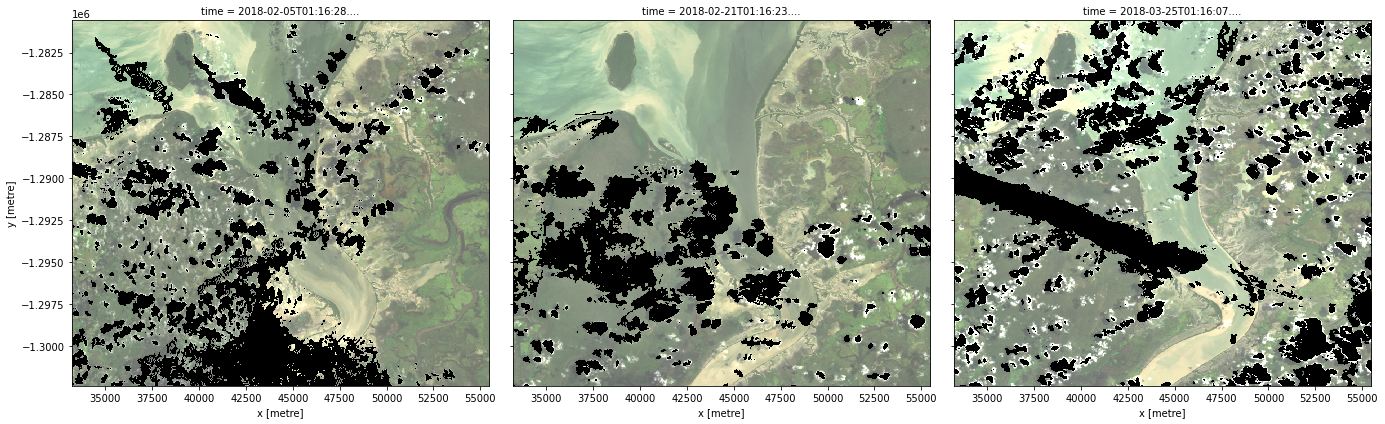

In [6]:
# Set the timesteps to visualise
timesteps = [2, 3, 5]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)


## Generate a geomedian

As you can see above, most satellite images will have at least some areas masked out due to clouds or other interference between the satellite and the ground. 
Running the `int_geomedian` function will generate a geomedian composite by combining all the observations in our `xarray.Dataset` into a single, complete (or near complete) image representing the geometric median of the time period.

> **Note:** Because our data was lazily loaded with `dask`, the geomedian algorithm itself will not be triggered until we call the `.compute()` method in the next step.

In [7]:
geomedian = int_geomedian(ds)

### Run the computation

The `.compute()` method will trigger the computation of the geomedian algorithm above.
This will take about a few minutes to run; view the `dask dashboard` to check the progress.

In [8]:
%%time
geomedian = geomedian.compute()

CPU times: user 386 ms, sys: 53.3 ms, total: 439 ms
Wall time: 19.1 s


If we print our result, you will see that the `time` dimension has now been removed and we are left with a single image that represents the geometric median of all the satellite images in our initial time series:

In [9]:
geomedian

<xarray.Dataset>
Dimensions:      (x: 742, y: 727)
Coordinates:
  * y            (y) float64 -1.281e+06 -1.281e+06 ... -1.302e+06 -1.302e+06
  * x            (x) float64 3.322e+04 3.326e+04 ... 5.542e+04 5.546e+04
Data variables:
    nbart_green  (y, x) int16 1405 1402 1400 1398 1394 ... 585 587 613 586 613
    nbart_red    (y, x) int16 1064 1061 1058 1049 1044 ... 684 715 718 672 732
    nbart_blue   (y, x) int16 1083 1083 1081 1080 1078 ... 399 400 422 411 424
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot the geomedian composite

Plotting the result, we can see that the geomedian image is much more complete than any of the individual images. 
We can also use this data in downstream analysis as the relationships between the spectral bands are maintained by the geometric median statistic.


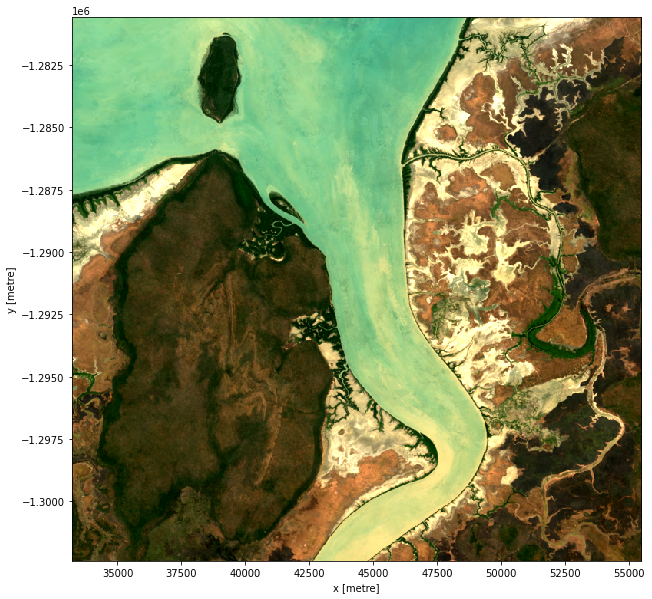

In [10]:
# Plot the result
rgb(geomedian, size=10)


## Running geomedian on grouped or resampled timeseries

In the notebook [Generating composites](./Generating_composites.ipynb), built in functions such as `mean` and `median` are run on timeseries data that has been resampled or grouped.  
We can use the same techniques with the geomedian function.

#### Resampling 

First we will split the timeseries into the desired groups.
Resampling can be used to create a new set of times at regular intervals:

 * `grouped = da_scaled.resample(time=1M)`
 
    * `'nD'` - number of days (e.g. `'7D'` for seven days)
    * `'nM'` - number of months (e.g. `'6M'` for six months)
    * `'nY'` - number of years (e.g. `'2Y'` for two years)

#### Group By
Grouping works by looking at part of the date, but ignoring other parts. 
For instance, `'time.month'` would group together all January data together, no matter what year it is from.

 * `grouped = da_scaled.groupby('time.month')`
 
     * `'time.day'` - groups by the day of the month (1-31)
     * `'time.dayofyear'` - groups by the day of the year (1-365)
     * `'time.week'` - groups by week (1-52) 
     * `'time.month'` - groups by the month (1-12)
     * `'time.season'` - groups into 3-month seasons:
         - `'DJF'` December, Jaunary, February
         - `'MAM'` March, April, May
         - `'JJA'` June, July, August
         - `'SON'` September, October, November
     * `'time.year'` - groups by the year
 
Here we will resample into three four-monthly groups (`'4M'`), with the group starting at the start of the month (represented by the `'S'` at the end).

In [11]:
grouped = ds.resample(time='4MS')
grouped

DatasetResample, grouped over '__resample_dim__' 
3 groups with labels 2018-01-01, ..., 2018-09-01.

Now we will apply the `int_geomedian` function to each resampled group using the `map` method.

Instead of calling `int_geomedian(ds)` on the entire array, we pass the `int_geomedian` function to `map` to apply it separately to each resampled group.

In [12]:
geomedian_grouped = grouped.map(int_geomedian)

We can now trigger the computation, and watch progress using the dask dashboard.

In [13]:
%%time
geomedian_grouped = geomedian_grouped.compute()

CPU times: user 512 ms, sys: 19.5 ms, total: 531 ms
Wall time: 14.3 s


We can plot the output geomedians, and see the change in the landscape over the year:

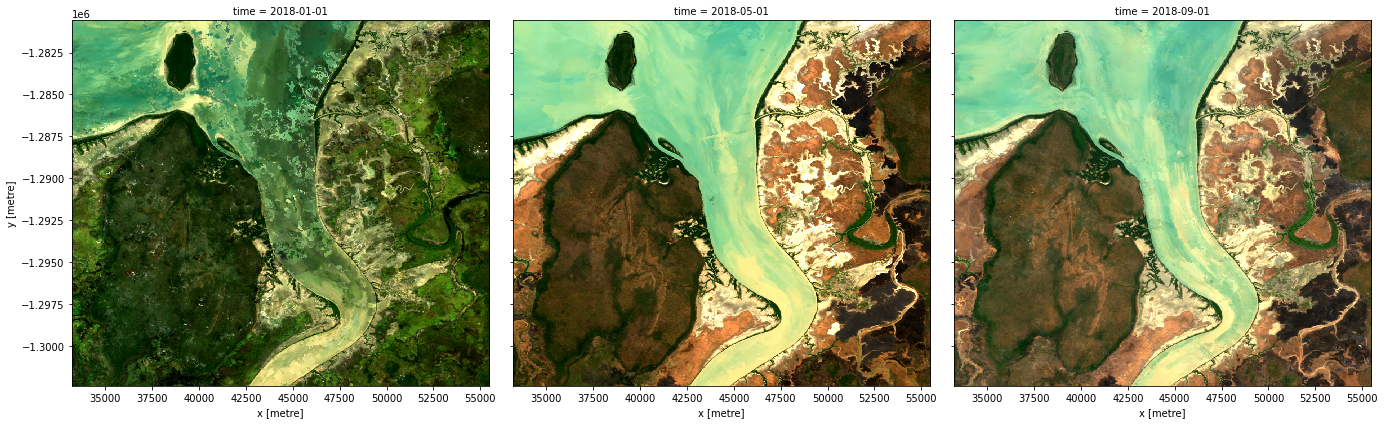

In [14]:
rgb(geomedian_grouped, col='time', col_wrap=4)

## Advanced: Geomedian on float arrays

The ODC has a useful function, [xr_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) that allows for calcuating geomedians on a `xarray.Dataset` (as well as `xr.DataArrays` and `numpy` arrays) with a `float` datatype.

To demonstrate this we will reload our dataset using `load_ard`, but this time not set `dtype='native'`. This will return our dataset in dtype `Float32`.

In [15]:
# Load available data
ds = load_ard(dc=dc, 
              products=['ga_ls8c_ard_3'],
              dask_chunks={'x': 2000, 'y': 2000},
              **query)

# Print output data
ds

Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 23 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 23, x: 742, y: 727)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -1.281e+06 -1.281e+06 ... -1.302e+06 -1.302e+06
  * x            (x) float64 3.322e+04 3.326e+04 ... 5.542e+04 5.546e+04
  * time         (time) datetime64[ns] 2018-01-04T01:16:45.170611 ... 2018-12-22T01:16:29.649254
Data variables:
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 727, 742), meta=np.ndarray>
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 727, 742), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 727, 742), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

**Note**: `xr_geomedian` has several parameters we can set that will control its functionality.  

* Setting `num_thread=1` will disable the internal threading and instead allow parallelisation with `dask`.  The `eps` parameter controls the number of iterations to conduct; a good default is `1e-7.`  

* For numerical stability, it can also be advisable to scale surface reflectance float values in the dataset to 0-1 (instead of 0-10,000 as is the default for LS8).  We can do this by using the helper functions `to_f32`. We do this in the code cell below before we compute the geomedian. Note, this is not an essential step.
    

In [16]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

#scale the values using the f_32 util function
ds_scaled = to_f32(ds,
                   scale=scale,
                   offset=offset)

In [17]:
geomedian = xr_geomedian(ds_scaled,
                         num_threads=1,
                         eps=1e-7,
                         ).compute()

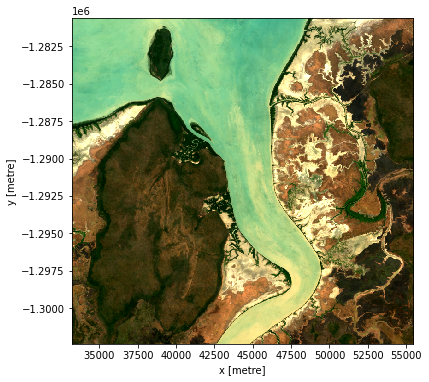

In [18]:
rgb(geomedian)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)